In [1]:
import os.path
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
)

documents = SimpleDirectoryReader("data").load_data()


incorrect startxref pointer(3)
parsing for Object Streams


In [14]:
# convert data/Critical-Systems.pdf to text and store it in data/Critical-Systems.txt
# this is a one-time operation
import PyPDF2

#reader = PyPDF2.PdfReader('data/Critical-Systems-Cybersecurity-Controls.pdf')
#text = "\n".join(page.extract_text() for page in reader.pages)

documents = SimpleDirectoryReader(input_files=['data/Critical-Systems-Cybersecurity-Controls.pdf']).load_data()

## What to skip
1. First page
2. pages with no text
3. Pages withg short paragraphs. Below on a simple way to calcualte the proper number of words to skip
4. Pages that start with 'Disclaimer' 


(array([3., 0., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 1., 1., 0., 2., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([  1.  ,   4.56,   8.12,  11.68,  15.24,  18.8 ,  22.36,  25.92,
         29.48,  33.04,  36.6 ,  40.16,  43.72,  47.28,  50.84,  54.4 ,
         57.96,  61.52,  65.08,  68.64,  72.2 ,  75.76,  79.32,  82.88,
         86.44,  90.  ,  93.56,  97.12, 100.68, 104.24, 107.8 , 111.36,
        114.92, 118.48, 122.04, 125.6 , 129.16, 132.72, 136.28, 139.84,
        143.4 , 146.96, 150.52, 154.08, 157.64, 161.2 , 164.76, 168.32,
        171.88, 175.44, 179.  , 182.56, 186.12, 189.68, 193.24, 196.8 ,
        200.36, 203.92, 207.48, 211.04, 214.6 

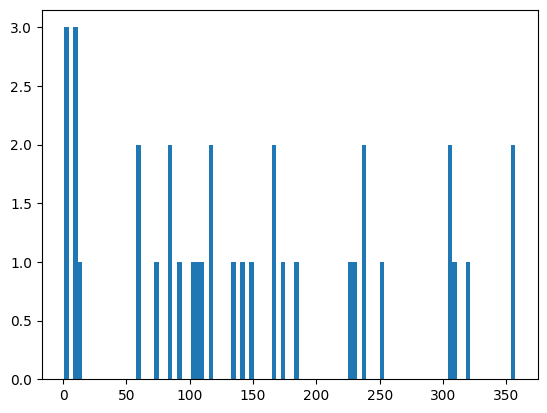

In [26]:
import matplotlib.pyplot as plt

words_per_page = [len(page.text.split(' ')) for page in documents]
plt.hist(words_per_page, bins=100)

In [28]:
# Skip first page
documents = documents[1:]

In [29]:
# Skip empty pages
_ = []
for document in documents:
    if len(document.text) > 0:
        _.append(document)
documents = _

In [30]:
# Skip all pages with less than 50 words
_ = []
for document in documents:
    if len(document.text.split(' ')) > 50:
        _.append(document)

documents = _

In [36]:
# Skip documents that start with 'Disclaimer'
_ = []
for document in documents:
    if not document.text.startswith('Disclaimer'):
        _.append(document)
documents = _

In [37]:
documents

[Document(id_='252654c4-f674-4de6-b210-a5fee0d3d966', embedding=None, metadata={'page_label': '6', 'file_name': 'Critical-Systems-Cybersecurity-Controls.pdf', 'file_path': 'data/Critical-Systems-Cybersecurity-Controls.pdf', 'file_type': 'application/pdf', 'file_size': 686781, 'creation_date': '2025-02-06', 'last_modified_date': '2025-02-06'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='6\nDocument Classification: Open\nCritical Systems Cybersecurity ControlsSharing Indicator:  White\nTraffic Light Protocol (TLP):\nThis marking protocol is widely used around the world. It has four colors (traffic lights):\n   Red – Personal, Confidentia